# Split image to text lines before OCR

In [2]:
import os.path
# Importing the OpenCV library
import cv2 as cv
from config import image_path, image_filename, start_row_number


In [3]:
# Reading the image using imread() function
image = cv.imread(os.path.join(image_path, image_filename))

# Extracting the height and width of an image
h, w = image.shape[:2]
# Displaying the height and width
print("Height = {}, Width = {}".format(h, w))

Height = 3888, Width = 5184


In [4]:
import numpy as np
import matplotlib.pyplot as plt

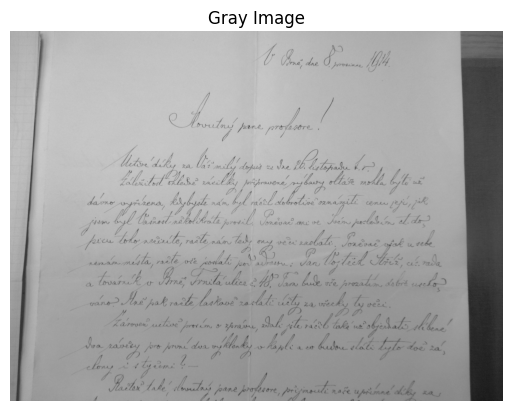

In [ ]:
# Convert the image to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Gray Image')
plt.show()

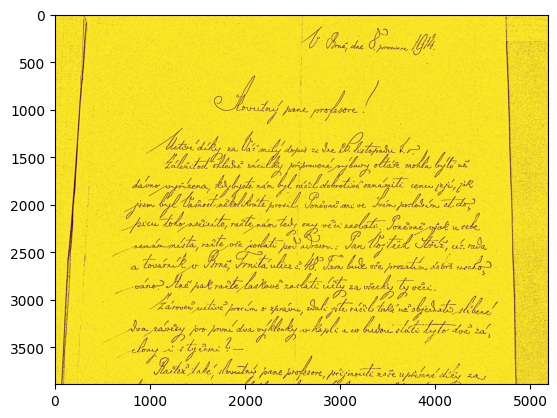

In [6]:
# Use adaptive thresholding to better separate text from light gray shadows
img = gray
mask = cv.adaptiveThreshold(
    img, 255, 
    cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv.THRESH_BINARY, 
    45,  # blockSize, can be tuned
     5    # Lower C to make thresholding less aggressive (darker result)
)
plt.imshow(mask)


In [7]:
(num_labels, labels, stats, _) = cv.connectedComponentsWithStats(mask)
# label 0 is background
# sort non-background by area (CC_STAT_AREA)
sorted_idx = np.argsort(stats[1:, cv.CC_STAT_AREA]) + 1
idx_largest = sorted_idx[-1]
stats_largest = stats[idx_largest]
mask_largest = (labels == idx_largest)

intgr = cv.integral(mask_largest.astype(np.uint8))

def integral_sum(x, y, w, h):
    return int(intgr[y+h, x+w] - intgr[y, x+w] - intgr[y+h, x] + intgr[y, x])

In [8]:
# how many pixels can be ignored as noise
noise_threshold = w * 0.05

bbox = stats_largest[[cv.CC_STAT_LEFT, cv.CC_STAT_TOP, cv.CC_STAT_WIDTH, cv.CC_STAT_HEIGHT]].tolist()
# could also start with the whole image but this gives it a head start

side_names = "top bottom left right".split()

while True:
    (x, y, w, h) = bbox
    print(f"bbox: {bbox}")

    if w <= 2 or h <= 2: # pointless box
        break

    counts = np.array([w, w, h, h])

    in_top    = integral_sum(x,     y,     w, 1)
    in_bottom = integral_sum(x,     y+h-1, w, 1)
    in_left   = integral_sum(x,     y,     1, h)
    in_right  = integral_sum(x+w-1, y,     1, h)
    ins = np.array([in_top, in_bottom, in_left, in_right])
    outs = counts - ins

    if not (outs > noise_threshold).any(): # nothing to crop anymore (done)
        break

    side_index = np.argmax(outs)

    match side_index:
        case 0: bbox = (x,   y+1, w,   h-1)
        case 1: bbox = (x,   y,   w,   h-1)
        case 2: bbox = (x+1, y,   w-1, h)
        case 3: bbox = (x,   y,   w-1, h)

bbox: [0, 0, 5184, 3888]
bbox: (0, 0, 5184, 3887)
bbox: (0, 0, 5184, 3886)
bbox: (0, 0, 5184, 3885)
bbox: (0, 0, 5184, 3884)
bbox: (0, 0, 5184, 3883)
bbox: (0, 0, 5184, 3882)
bbox: (0, 0, 5184, 3881)
bbox: (0, 0, 5184, 3880)
bbox: (0, 0, 5184, 3879)
bbox: (0, 0, 5184, 3878)
bbox: (0, 0, 5184, 3877)
bbox: (0, 0, 5184, 3876)
bbox: (0, 0, 5184, 3875)
bbox: (0, 0, 5184, 3874)
bbox: (0, 0, 5184, 3873)
bbox: (0, 0, 5184, 3872)
bbox: (0, 0, 5184, 3871)
bbox: (0, 0, 5184, 3870)
bbox: (0, 0, 5184, 3869)
bbox: (0, 0, 5184, 3868)
bbox: (0, 0, 5184, 3867)
bbox: (0, 0, 5184, 3866)
bbox: (0, 0, 5184, 3865)
bbox: (0, 0, 5184, 3864)
bbox: (0, 0, 5184, 3863)


(0, 0, 5184, 3863)


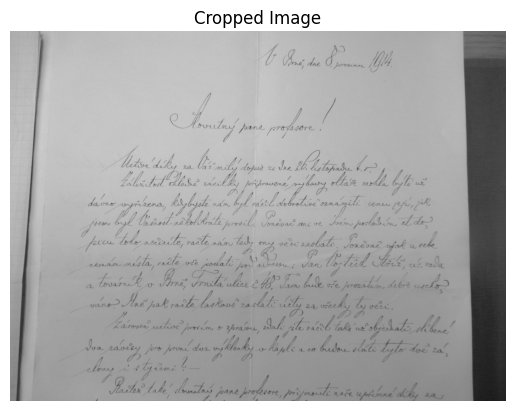

In [9]:
print(bbox)
# crop image to fit bounding box
crop = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
plt.imshow(crop, cmap='gray')
plt.axis('off')
plt.title('Cropped Image')
plt.show()

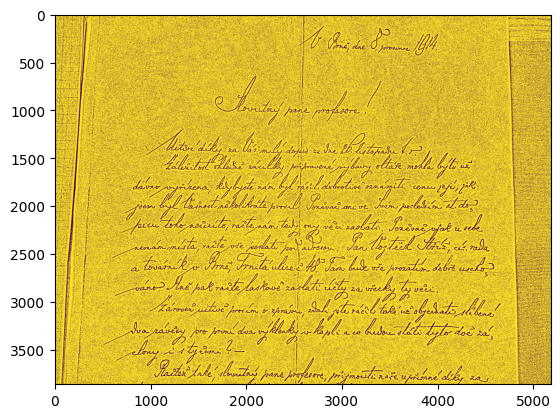

In [10]:
img = crop
# Improve contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
mask = clahe.apply(img)

mask = cv.adaptiveThreshold(
    mask, 255, 
    cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv.THRESH_BINARY, 
    45,  # blockSize, can be tuned
     5    # Lower C to make thresholding less aggressive (darker result)
)
plt.imshow(mask)


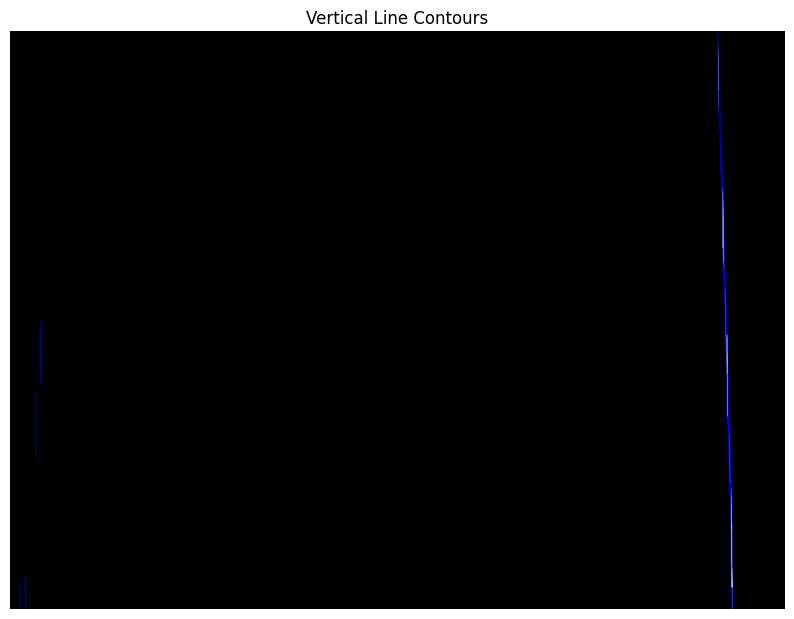

In [11]:
# Find long vertical lines near the sides and crop image between them

# Use the "improved" image (binarized) for line detection
# We'll use morphological operations to enhance vertical lines, then find contours

# Enhance vertical lines
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, mask.shape[0] // 10))
vertical_lines = cv.morphologyEx(mask, cv.MORPH_OPEN, vertical_kernel, iterations=1)

# Find contours of vertical lines
contours, _ = cv.findContours(vertical_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Show detected contours on the vertical_lines image
contour_img = cv.cvtColor(vertical_lines, cv.COLOR_GRAY2BGR)
cv.drawContours(contour_img, contours, -1, (0, 0, 255), 2)

plt.figure(figsize=(10, 12))
plt.imshow(contour_img)
plt.axis('off')
plt.title('Vertical Line Contours')
plt.show()


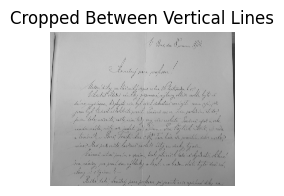

In [12]:

# Filter for long vertical lines near the left and right sides
height, width = img.shape
min_line_length = int(0.05 * height)  # at least 70% of image height
side_margin = int(0.3 * width)      # within 10% from sides

left_x = None
right_x = None

for cnt in contours:
    x, y, cw, ch = cv.boundingRect(cnt)
    if ch > min_line_length:
        # Left side
        if x < side_margin:
            if left_x is None or x + cw > left_x:
                left_x = x + cw  # crop to the right of the line
        # Right side
        if x + cw > w - side_margin:
            if right_x is None or x > right_x:
                right_x = x      # crop to the left of the line

# Fallback if no lines found: use full image
if left_x is None:
    left_x = 0
if right_x is None:
    right_x = w

# Crop between the detected vertical lines
cropped_between_lines = img[:, left_x:right_x]

plt.figure(figsize=(10, 2))
plt.imshow(cropped_between_lines, cmap='gray')
plt.axis('off')
plt.title('Cropped Between Vertical Lines')
plt.show()


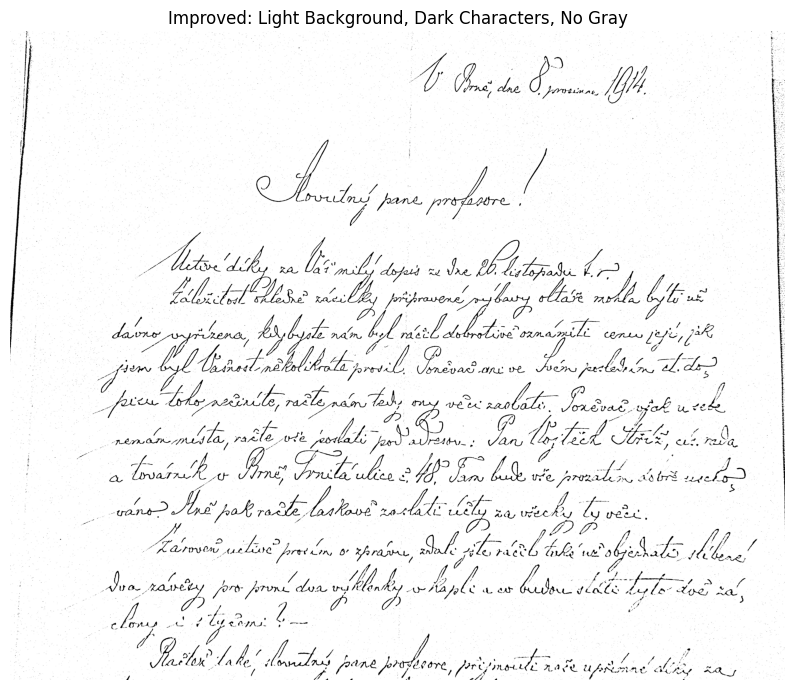

In [13]:
img = cropped_between_lines

# Improve image: increase lightness, keep dark characters, remove gray background

# Step 1: Gamma correction to brighten the image and background
gamma = 2.5  # >1 brightens, <1 darkens; tune as needed
img_float = img.astype(np.float32) / 255.0
img_gamma = np.power(img_float, 1.0 / gamma)
img_gamma = np.clip(img_gamma * 255, 0, 255).astype(np.uint8)

# Step 2: Adaptive thresholding to handle uneven illumination
adaptive = cv.adaptiveThreshold(
    img_gamma,
    maxValue=255,
    adaptiveMethod=cv.ADAPTIVE_THRESH_MEAN_C,
    thresholdType=cv.THRESH_BINARY_INV,
    blockSize=25,
    C=5
)
# Invert so text is black, background is white
adaptive = 255 - adaptive

# Step 3: Otsu's thresholding to remove remaining gray pixels in the background
_, adjusted = cv.threshold(adaptive, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.figure(figsize=(10, 12))
plt.imshow(adjusted, cmap='gray')
plt.axis('off')
plt.title('Improved: Light Background, Dark Characters, No Gray')
plt.show()





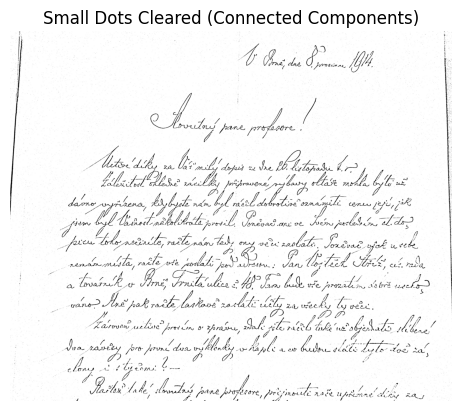

In [15]:
img = adjusted
# clean dark small dots
# Clean dark small dots using connected components
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=4)
max_dot_area = 30  # maximum area for a dot to be considered noise (tune as needed)
# Create a mask for noise (small components)
noise_mask = np.zeros_like(img, dtype=np.uint8)
for i in range(1, num_labels):  # skip background
    if i % 1000 == 0:
        print(i)
    if stats[i, cv.CC_STAT_AREA] <= max_dot_area:
        noise_mask[labels == i] = 255

# Remove noise from the image
clean_no_dots = img.copy()
clean_no_dots[noise_mask == 255] = 255  # set noise pixels to white

plt.imshow(clean_no_dots, cmap='gray')
plt.axis('off')
plt.title('Small Dots Cleared (Connected Components)')
plt.show()




In [ ]:

# save the result
extension = image_filename.split('.')[-1]
output_path = os.path.join(image_path, 
                           image_filename.replace(f'.{extension}',
                           '_clean.tif'))
cv.imwrite(output_path, clean_no_dots)

True

Počet detekovaných řádků: 15670


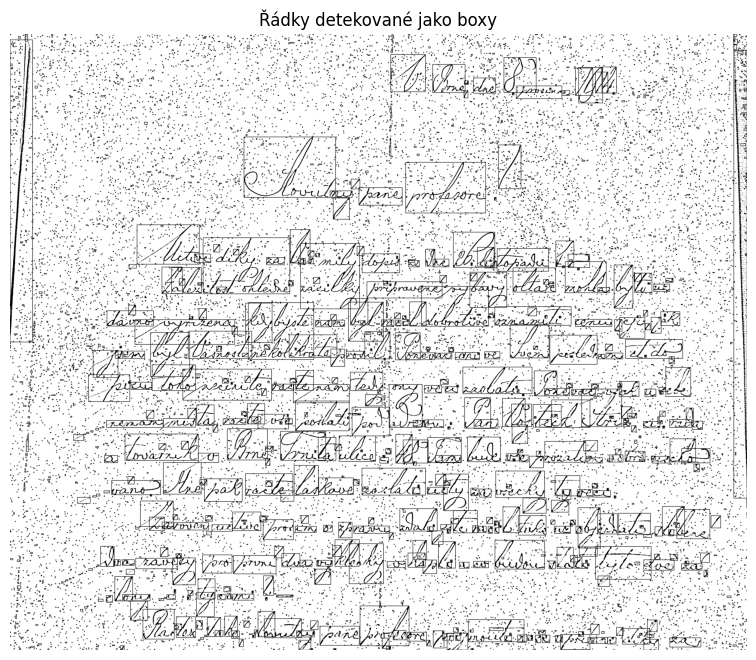

In [16]:
img = clean_no_dots
# 3. Dilatace pro spojení písmen/slov do jednoho řádku
kernel = np.ones((3, 3), np.uint8)
grad = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)

_, bw = cv.threshold(grad, 0.0, 255.0, cv.THRESH_BINARY | cv.THRESH_OTSU)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 3))
connected = cv.morphologyEx(bw, cv.MORPH_CLOSE, kernel)

# 4. Najdi kontury
contours, _ = cv.findContours(connected, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# 5. Získej bounding boxy a seřaď je shora dolů
boxes = [cv.boundingRect(c) for c in contours]
boxes0 = sorted(boxes, key=lambda b: b[1])  # podle Y (nahoru-dolů)
print(f"Počet detekovaných řádků: {len(boxes)}")

# 6. Vykresli boxy a/nebo ulož oříznuté řádky
contour_image = img.copy()
for i, (x, y, w, h) in enumerate(boxes):
    cv.rectangle(contour_image, (x, y), (x + w, y + h), (0, 99, 0), 2)
  
# 7. Zobraz
plt.figure(figsize=(12, 8))
plt.imshow(cv.cvtColor(contour_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Řádky detekované jako boxy")
plt.show()


In [17]:
line_percentil = 90
char_percentil = 50
boxes = boxes0
boxes_new = []
for i, (x, y, w, h) in enumerate(boxes):
    if h < 5:  # Too small box, noise
        continue
    if h > height / 5 and h / w > 3:  # Too high box, vertical line
        continue
    boxes_new.append((x, y, w, h))
boxes = boxes_new

character_size = np.percentile([box[3] for box in boxes], char_percentil)
print(f"Výška znaku ({char_percentil}. percentil): {character_size}")
line_height = np.percentile([box[3] for box in boxes], line_percentil)
print(f"Výška řádku ({line_percentil}. percentil): {line_height}")
while line_height / character_size > 3:
    boxes_new = []
    for i, (x, y, w, h) in enumerate(boxes):
        if h + w < character_size / 2 + 1:  # Příliš malý box, pravděpodobně šum
            continue
        if h > line_height * 3: # Too big box, split it
            h2 = int(h / 2)
            boxes_new.append((x, y, w, h2+1))
            boxes_new.append((x, y + h2, w, h - h2 + 1))
        else:
            boxes_new.append((x, y, w, h))
    boxes = sorted(boxes_new, key=lambda b: b[1] + b[3] / 2)  
    # znovu seřadíme podle Y
    character_size = character_size * 2
    line_height = np.percentile([box[3] for box in boxes], line_percentil)
print("Number of detected boxes", len(boxes))
print(f"Výška řádku ({line_percentil}. percentil): {line_height}")
print(f"Výška znaku ({char_percentil}. percentil): {character_size}")

Výška znaku (50. percentil): 7.0
Výška řádku (90. percentil): 48.0
Number of detected boxes 2166
Výška řádku (90. percentil): 78.0
Výška znaku (50. percentil): 28.0


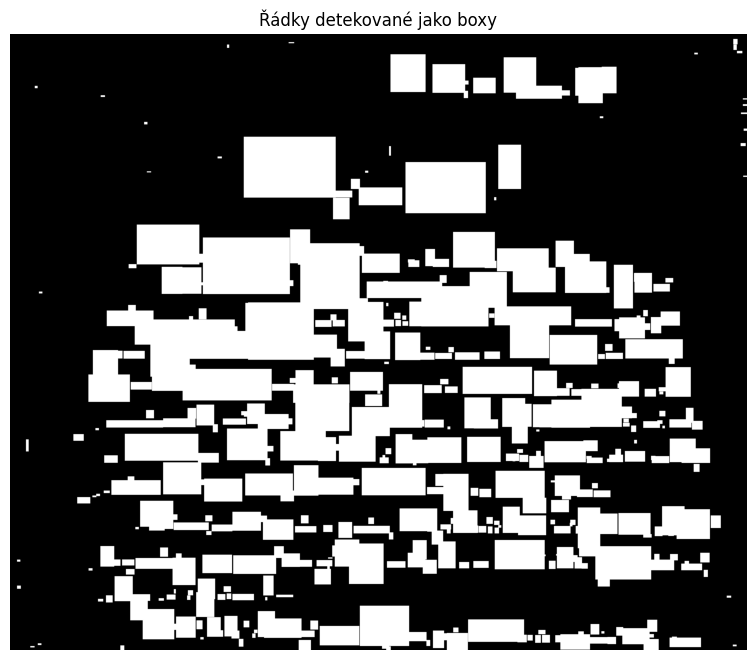

In [18]:
# blank image with size as clean
mask_image = np.zeros_like(clean_no_dots)
for (x, y, w, h) in boxes:
    if w + h > character_size:
        mask_image[y - 1:y + h + 1, x - 1:x + w + 1] = 255
plt.figure(figsize=(12, 8))
plt.imshow(mask_image, cmap='gray')
plt.axis('off')
plt.title("Řádky detekované jako boxy")
plt.show()



In [25]:
# 8. Oříznutí řádků a uložení
current_line = 0
current_box_number = 0
box = boxes[current_box_number]
rows = []
status = "blank"
counts = 0
row_width = 0
        
height, width = clean_no_dots.shape
# move from top to bottom
while current_line < clean_no_dots.shape[0]:
    # count white pixels in the line
    counts_before = counts
    counts = clean_no_dots.shape[1] - integral_sum(0, current_line, clean_no_dots.shape[1]-1, 1)
    row_width = max(row_width, counts)
        
    if status == "blank": 
        if counts > character_size * 2: # row starts
            status = "row"
    elif status == "row":
        if row_width > character_size * 3:
            if counts < character_size / 4:
                status = "end"
            elif counts < row_width / 4:
                status = "end"
    if status == "end":
        (x, y, w, h) = box
        current_mask = []
        # find all boxes where middle is uper then row's bottom
        while (box[1] + box[3] / 2 < current_line + character_size * 2 and
               current_box_number < len(boxes) - 1): # add box to row
            current_mask.append(box)
            x = min(box[0], x) 
            y = min(box[1], y)
            x1 = max(box[0] + box[2], x + w)
            y1 = max(box[1] + box[3], y + h)
            w = x1 - x
            h = y1 - y
            current_box_number += 1
            box = boxes[current_box_number]
        
        rows.append(((x, y, w, h), current_mask))
        status = "blank"
        row_width = counts
    
    current_line += 1
        
        
# Show number of detected lines
print(f"Počet detekovaných řádků: {len(rows)}")

Počet detekovaných řádků: 14


Řádek 0: 0, 0, 4616, 450


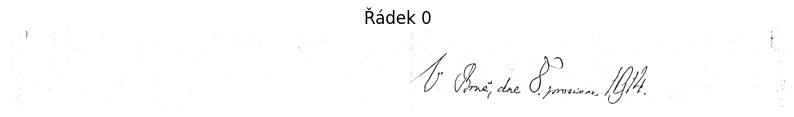

Řádek 1: 0, 443, 4616, 718


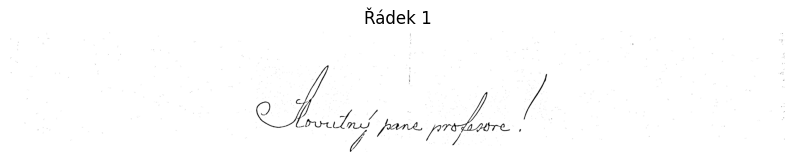

Řádek 2: 56, 1095, 4551, 451


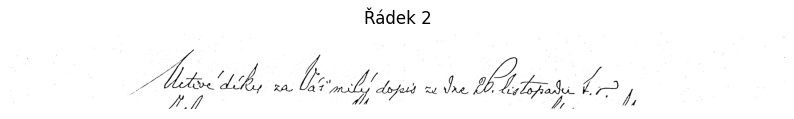

Řádek 3: 84, 1448, 4532, 276


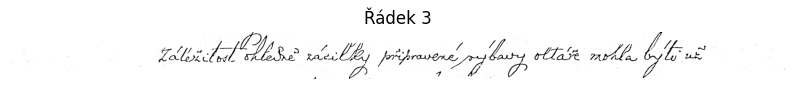

Řádek 4: 26, 1658, 4487, 277


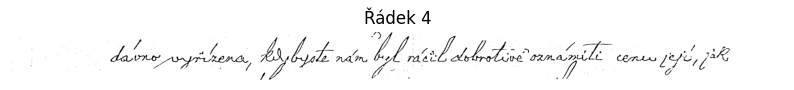

Řádek 5: 0, 1862, 4524, 286


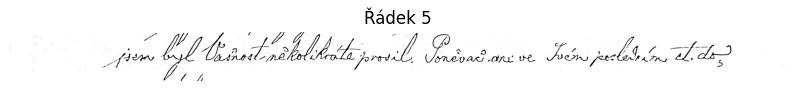

Řádek 6: 8, 2068, 4416, 277


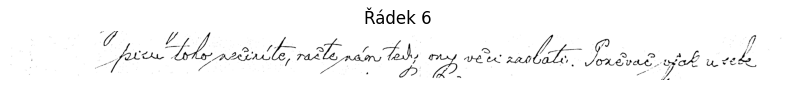

Řádek 7: 60, 2280, 4448, 287


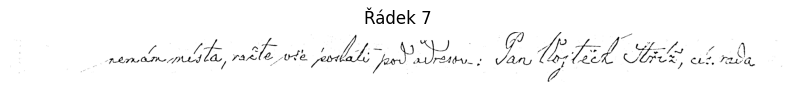

Řádek 8: 92, 2475, 4449, 312


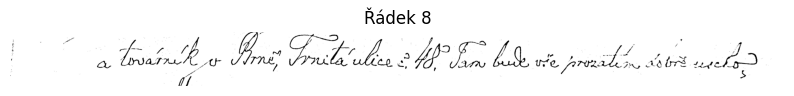

Řádek 9: 85, 2705, 4531, 285


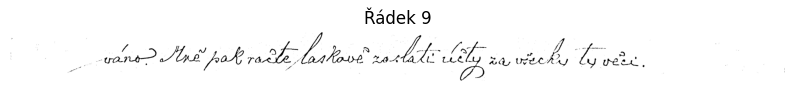

Řádek 10: 0, 2909, 4482, 315


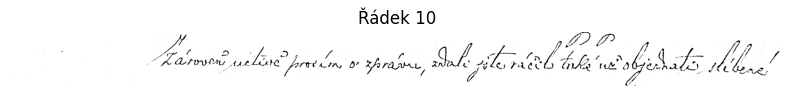

Řádek 11: 0, 3171, 4607, 280


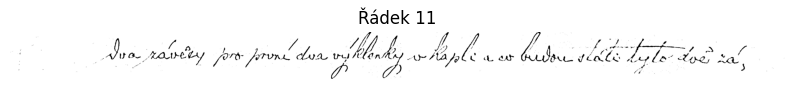

Řádek 12: 43, 3369, 4522, 307


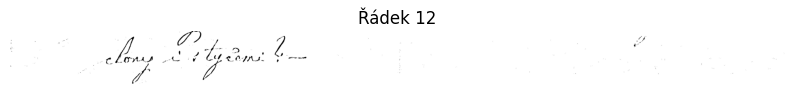

Řádek 13: 26, 3586, 4574, 277


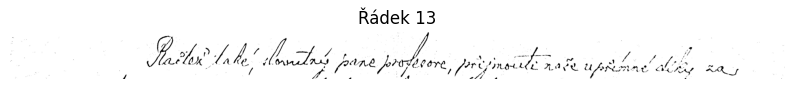

In [26]:
# Display and save each line
character_size = int(character_size)
for i, (row, mask) in enumerate(rows):
    x, y, w, h = row
    row_image = clean_no_dots[y:y + h, x:x + w]
    mask_image = np.zeros((h, w), dtype=clean_no_dots.dtype)
    for box in mask:
        mask_image[box[1] - y:box[1]  + box[3] - y, box[0] - x:box[0] + box[2] - x] = 255
    row_image = np.where(mask_image > 0, row_image, 255)
    print(f"Řádek {i}: {x}, {y}, {w}, {h}")
    plt.figure(figsize=(10, 2)) 
    plt.imshow(row_image, cmap='gray')
    plt.axis('off')
    plt.title(f"Řádek {i}")
    plt.show()
    # Save each line
    output_filename = image_filename.replace('.', f'_line_{i + start_row_number}.')
    output_line_path = os.path.join(f"{image_path}/lines", 
                                    output_filename)
    cv.imwrite(output_line_path, row_image)